# Pylandtemp: a python library for computing land surface temperature from Landsat satellite images


##### Presentation by: [Oladimeji Mudele](https://www.linkedin.com/in/dimejimudele/) (Incoming Post-Doc, Harvard University)


This notebook has been created as a poster to be submitted to Scipy2022 event for virtual presentation

Land surface temperature (LST) is an important parameter in the physical processes of Earth's environment both at local and global scales. 

**Pylandtemp** is a Python library that provides a simple API for computing global land surface temperature and emissivity from NASA's Landsat satellite images. It contains some implementations of Single-Channel and split-window techniques. More methodologies under these groups will be added in the future.

Below is a simple workflow for applying the library for computing [NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/), Land Surface Emissivity and LST.

Before running this notebook, run this command in your terminal `pip install pylandtemp` or simply copy and paste this `!pip install pylandtemp` into a cell and run

# 1.  Import python dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio

# 2. Location

For this tutorial, we’ll use the NIR and Red bands from a Landsat-8 scene above part of the central valley and the Sierra Nevada in California. We’ll be using Level 1TP datasets, orthorectified, map-projected images containing radiometrically calibrated data.

# 3. Load sample landsat image from Google cloud

Note: you can also load from local disk or google drive as you wish. I have used Google cloud for convenience.

In [7]:
print('Landsat on Google cloud:')
print('=========================')
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'


print('Data info')
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google cloud:
Data info
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


# 4. Load image ands needed from land surface temperature computation
- Red: Band 4 in our Landsat image (The red band in need )
- Near-Infrared (NIR): Band 5
- Thermal infrared 1: Band 10
- Thermal infrared 2: Band 11


Here, I have used `rasterio` to load the images/bands needed. If you don't have it installed, use the command `pip install rasterio`

In [5]:
url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4) # red band image
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5) # nirimage
tempband10 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(10) # Thermal infrared 1 (Band 10 landsat 8)
tempband11 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(11)

In [14]:
with rasterio.open(url+redband) as src:
    redImage = src.read(1).astype('f4')

with rasterio.open(url+nirband) as src:
    nirImage = src.read(1).astype('f4')
    
with rasterio.open(url+tempband10) as src:
    tempImage10 = src.read(1).astype('f4')

with rasterio.open(url+tempband11) as src:
    tempImage11 = src.read(1).astype('f4')

# 5. Compute the Normalized Difference Vegetation Index (NDVI) image from the Red and NIR images 

We need the NDVI (and in some cases) the red band image to obtain our emissivity image.
The Normalized Difference Vegetation Index is a simple indicator that can be used to assess whether the target includes healthy vegetation. This calculation uses two bands of a multispectral image dataset, the Red and Near-Infrared (NIR) bands.

This stage is only done here in the tutorial for completion. The `emissivity` module of `pylandtemp` handles the NDVI computation.

In [9]:
from pylandtemp import ndvi 

In [18]:
mask = redImage == 0
ndviImage = ndvi(nirImage, redImage, mask=mask)

### Visualize the NDVI

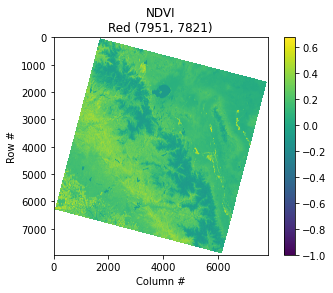

In [19]:
plt.imshow(ndviImage)
plt.colorbar()
plt.title('{}\nRed {}'.format('NDVI', ndviImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 6.  Compute emissivity with three different methods

In [20]:
from pylandtemp import emissivity

In [93]:

emissivityGopinadh10, emissivityGopinadh11  = emissivity(ndviImage, redImage, emissivity_method='gopinadh') # Method 1
emissivityAvdan10, emissivityAvdan11 = emissivity(ndviImage, redImage, emissivity_method='avdan') # method 2
emissivityXiaolei10, emissivityXiaolei11 = emissivity(ndviImage, redImage, emissivity_method='xiaolei') # method 3

In [51]:
# Extracting the band 10 emissivity values for comparison
emissivityAvdan10 = emissivityAvdan10[~np.isnan(emissivityAvdan10)]
emissivityXiaolei10 = emissivityXiaolei10[~np.isnan(emissivityXiaolei10)]
emissivityGopinadh10 = emissivityGopinadh10[~np.isnan(emissivityGopinadh10)]

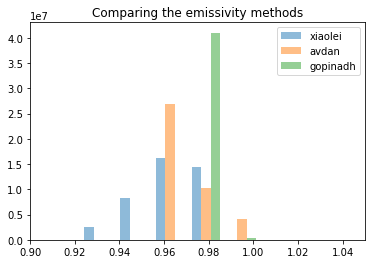

In [74]:
nBins = 20

plt.hist(
    [emissivityXiaolei10, emissivityAvdan10,emissivityGopinadh10],
    bins=nBins, alpha = 0.5, 
    label=['xiaolei', 'avdan', 'gopinadh']
)
plt.title('Comparing the emissivity methods')
plt.xlim([0.9, 1.05])
plt.legend()
plt.show()

### Visualize Emissivity

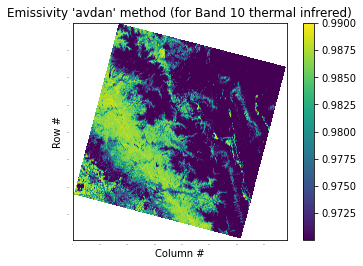

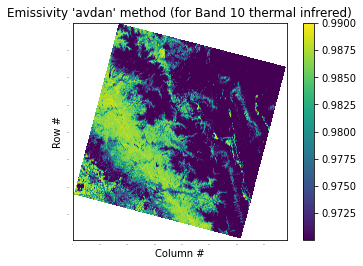

In [81]:
plt.imshow(emissivityAvdan10)
plt.colorbar()
plt.title("Emissivity 'avdan' method (for Band 10 thermal infrered)")
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.tick_params(which = 'both', size = 0, labelsize = 0)
plt.show()


plt.imshow(emissivityAvdan11)
plt.colorbar()
plt.title("Emissivity 'avdan' method (for Band 11 thermal infrered)")
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.tick_params(which = 'both', size = 0, labelsize = 0)
plt.show()

We can see from the above method that `gopinadh` method produces a more homogenous emissivity value than `advan` or `xiaolei`. Probably not a good result. Hence, we should use `advan` or `xiaolei` for all further computations.

# 7. Computing LST with single channel method

In [84]:
from pylandtemp import single_window, split_window

In [114]:
lstSingleWindow = single_window(tempImage10, redImage, nirImage)

# 8. Computing LST with split window method

In [111]:
lstJiminez  = split_window(
    tempImage10, 
    tempImage11, 
    redImage, 
    nirImage, 
    lst_method='jiminez-munoz', 
    emissivity_method='avdan',
    unit='kelvin'
)


lstSobrinos = split_window(
    tempImage10, 
    tempImage11, 
    redImage, 
    nirImage, 
    lst_method='sobrino-1993', 
    emissivity_method='avdan',
    unit='kelvin'
)


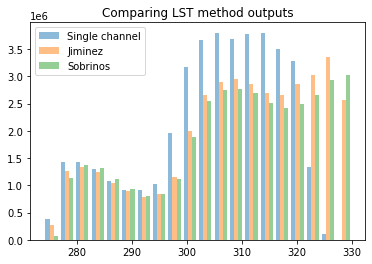

In [116]:
nBins = 20

plt.hist(
    [
        lstSingleWindow[~np.isnan(lstSingleWindow)],
        lstJiminez[~np.isnan(lstJiminez)], 
        lstSobrinos[~np.isnan(lstSobrinos)]
    ],
    bins=nBins, alpha = 0.5, 
    label=['Single channel', 'Jiminez', 'Sobrinos']
)
plt.title('Comparing LST method outputs')
#plt.xlim([0.9, 1.05])
plt.legend()
plt.show()

As can be seen, there is correlation between results from both methods split window methods. The single channels methods underestimates high temperatures and oveestimates mid temperatures.

### Visualize LST

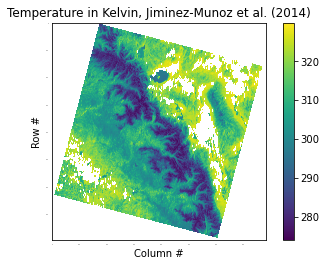

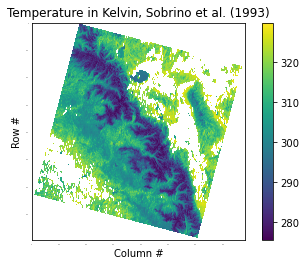

In [113]:
plt.imshow(lstJiminez)
plt.colorbar()
plt.title("Temperature in Kelvin, Jiminez-Munoz et al. (2014)")
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.tick_params(which = 'both', size = 0, labelsize = 0)
plt.show()


plt.imshow(lstSobrinos)
plt.colorbar()
plt.title("Temperature in Kelvin, Sobrino et al. (1993)")
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.tick_params(which = 'both', size = 0, labelsize = 0)
plt.show()

Even though  Landsat computes LST for us in one of its new product "landsat science product", The library would still find application with scientists who want to compare different LST computation methods. For example, when proposing an improved method. This one major use case for now.

# 9. Next steps

- Include batch processing functionality: i.e methods thatb enable the download of several files and calculation LST for those files at once.
- Add new methods for LST and emissivity from the literature
- Expand team of contributors

I hereby acknowledge the support of [Moses Koledoye](https://www.linkedin.com/in/moseskoledoye/) in the continuous development of this library.